In [1]:
import pandas as pd
from ebmdatalab import bq
import numpy as np

# Import data

In [2]:
from ebmdatalab import bq

# save table in BQ as follows
'''SELECT pct, practice, chemical, bnf_code, bnf_name, SUM(items) AS items, SUM(actual_cost) AS actual_cost, SUM(quantity) AS quantity, CAST(month AS DATE) AS month 
FROM `ebmdatalab.hscic.normalised_prescribing_standard` p

LEFT JOIN `hscic.bnf` b ON p.bnf_code = b.presentation_code

WHERE SUBSTR(bnf_code,1,9) IN (
    '0212000AA', --Rosuvastatin Calcium 
    '0212000AC', --Simvastatin & Ezetimibe
    '0212000B0', --Atorvastatin
    '0212000C0', --Cerivastatin 
    '0212000M0', --Fluvastatin Sodium
    '0212000X0', --Pravastatin Sodium 
    '0212000Y0') --Simvastatin

GROUP BY 
 pct, practice, chemical, bnf_code, bnf_name, month
 
ORDER BY
month, bnf_code'''

# for practice- and chemical-level use following
'''SELECT pct, practice, chemical, SUM(items) AS items, SUM(actual_cost) AS actual_cost, SUM(quantity) AS quantity, CAST(month AS DATE) AS month ,
SUM(CASE WHEN concat(SUBSTR(bnf_code,1,9),SUBSTR(bnf_code,-2,2)) NOT IN (
    '0212000AAAA', --Rosuvastatin Calc_Tab 10mg (brand, generic) 
    '0212000AAAB', --Rosuvastatin Calc_Tab 20mg (brand, generic) 
    '0212000AAAC', --Rosuvastatin Calc_Tab 40mg (brand, generic) 
    '0212000B0AB', --Atorvastatin_Tab 20mg (brand, generic)
    '0212000B0AC', --Atorvastatin_Tab 40mg (brand, generic) 
    '0212000B0AD', --Atorvastatin_Tab 80mg (brand, generic)
    '0212000B0AN', --Atorvastatin_Tab 30mg (brand, generic)
    '0212000B0AP', --Atorvastatin_Tab 60mg (brand, generic)
    '0212000Y0AH') --Simvastatin_Tab 80mg (brand, generic)
    THEN items ELSE 0 END) AS low_med_dose_items,
SUM(CASE WHEN concat(SUBSTR(bnf_code,1,9),SUBSTR(bnf_code,-2,2)) NOT IN (
    '0212000AAAD', --Rosuvastatin Calc_Tab 5mg (brand, generic) 
    '0212000AAAA', --Rosuvastatin Calc_Tab 10mg (brand, generic) 
    '0212000AAAB', --Rosuvastatin Calc_Tab 20mg (brand, generic) 
    '0212000AAAC', --Rosuvastatin Calc_Tab 40mg (brand, generic) 
    '0212000B0AA', -- Atorvastatin_Tab 10mg (brand, generic)
    '0212000B0AL', -- Atorvastatin_Tab Chble 10mg (brand, generic) 
    '0212000B0AB', --Atorvastatin_Tab 20mg (brand, generic)
    '0212000B0AC', --Atorvastatin_Tab 40mg (brand, generic) 
    '0212000B0AD', --Atorvastatin_Tab 80mg (brand, generic)
    '0212000B0AN', --Atorvastatin_Tab 30mg (brand, generic)
    '0212000B0AP', --Atorvastatin_Tab 60mg (brand, generic)
    '0212000Y0AD', --Simvastatin_Tab 40mg (brand, generic)
    '0212000Y0AH') --Simvastatin_Tab 80mg (brand, generic)
    THEN items ELSE 0 END) AS low_med_dose_items_hi_pri

FROM `ebmdatalab.helen.prescribing_statins_all_and_lowdose` p


WHERE SUBSTR(bnf_code,1,9) IN (
    '0212000AA', --Rosuvastatin Calcium 
    '0212000AC', --Simvastatin & Ezetimibe
    '0212000B0', --Atorvastatin
    '0212000C0', --Cerivastatin 
    '0212000M0', --Fluvastatin Sodium
    '0212000X0', --Pravastatin Sodium 
    '0212000Y0') --Simvastatin

GROUP BY 
 pct, practice, chemical, month
 
ORDER BY
month'''


# Import practice-level data

sql = '''-- practice data by chemical

SELECT p.month, p.practice, chemical, 
SUM(items) AS items, SUM(actual_cost) AS actual_cost, SUM(quantity) AS quantity
FROM `ebmdatalab.helen.prescribing_section_2_12` p

INNER JOIN ebmdatalab.hscic.practices prac
ON p.practice = prac.code
  AND prac.setting = 4
  
GROUP BY
month, practice, chemical'''


#df = bq.cached_read(sql, csv_path='statins_practice_level.zip')  # add `use_cache=False` to override

# file too large to load directly - use csv

df = pd.read_csv('helen_prescribing_statins_all_and_lowdose_chem.csv')
df.head()

,pct,practice,chemical,items,actual_cost,quantity,month,low_med_dose_items,low_med_dose_items_hi_pri
0,99E,F81666,Simvastatin,211,278.81,5861,2010-08-01,211,101
1,10X,J82619,Atorvastatin,20,616.20,924,2010-08-01,10,0
2,03J,B85008,Fluvastatin Sodium,2,13.72,56,2010-08-01,2,2
3,15D,K81046,Pravastatin Sodium,12,63.61,588,2010-08-01,12,12
4,04G,K83010,Pravastatin Sodium,36,93.51,847,2010-08-01,36,36


In [3]:
prac = df.copy()
prac["month"]= pd.to_datetime(prac.month, utc=True)
prac["proportion_lm"] = prac["low_med_dose_items"]/prac["items"]
prac.head()

,pct,practice,chemical,items,actual_cost,quantity,month,low_med_dose_items,low_med_dose_items_hi_pri,proportion_lm
0,99E,F81666,Simvastatin,211,278.81,5861,2010-08-01 00:00:00+00:00,211,101,1.0
1,10X,J82619,Atorvastatin,20,616.20,924,2010-08-01 00:00:00+00:00,10,0,0.5
2,03J,B85008,Fluvastatin Sodium,2,13.72,56,2010-08-01 00:00:00+00:00,2,2,1.0
3,15D,K81046,Pravastatin Sodium,12,63.61,588,2010-08-01 00:00:00+00:00,12,12,1.0
4,04G,K83010,Pravastatin Sodium,36,93.51,847,2010-08-01 00:00:00+00:00,36,36,1.0


### Practice population data

note running this cell takes some time

In [4]:
sql_prac_p = '''
SELECT p.code as practice, stat.month, SUM(total_list_size) AS total_list_size
FROM ebmdatalab.hscic.practices p 
LEFT JOIN ebmdatalab.hscic.practice_statistics_all_years stat ON stat.practice = p.code
WHERE setting = 4
GROUP BY practice, month'''

prac_p = bq.cached_read(sql_prac_p, csv_path='prac_p.csv', use_cache=False)  # add `use_cache=False` to override


prac_p["total_list_size"] = prac_p["total_list_size"].astype("float")
prac_p["month"]= pd.to_datetime(prac_p.month, utc=True)
prac_p.info()

C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 803270 entries, 0 to 3269
Data columns (total 3 columns):
practice           803270 non-null object
month              803235 non-null datetime64[ns, UTC]
total_list_size    803235 non-null float64
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 24.5+ MB


# National trends

In [14]:
national = prac.copy().groupby(["practice","month"]).sum().reset_index()

national = national.merge(prac_p,on=["month","practice"])

national = national.groupby("month").sum().reset_index()
national["items_per_thou"] = 1000*national["items"]/national["total_list_size"]
national["lmdose_items_per_thou"] = 1000*national["low_med_dose_items"]/national["total_list_size"]
national["lmhp_items_per_thou"] = 1000*national["low_med_dose_items_hi_pri"]/national["total_list_size"]
national["proportion_lm"] = national["low_med_dose_items"]/national["items"]
national["proportion_lm_hp"] = national["low_med_dose_items_hi_pri"]/national["items"]

national.head()

,month,items,actual_cost,quantity,low_med_dose_items,low_med_dose_items_hi_pri,proportion_lm,total_list_size,items_per_thou,lmdose_items_per_thou,lmhp_items_per_thou,proportion_lm_hp
0,2010-10-01 00:00:00+00:00,4474502,33059162.03,158157900,3611186,1280966,0.807059,54460771.0,82.160093,66.308022,23.520894,0.286281
1,2010-11-01 00:00:00+00:00,4633820,34021001.18,163358845,3741368,1320011,0.807405,54463212.0,85.081651,68.695324,24.236745,0.284865
2,2010-12-01 00:00:00+00:00,4959368,36443462.60,174964460,4002797,1404369,0.807118,54461684.0,91.061598,73.497489,25.786368,0.283175
3,2011-01-01 00:00:00+00:00,4431089,32189438.27,155684407,3578879,1252138,0.807675,54560095.0,81.214833,65.595175,22.949703,0.282580
4,2011-02-01 00:00:00+00:00,4272446,30920164.93,149366278,3448701,1198643,0.807196,54569594.0,78.293527,63.198216,21.965401,0.280552


C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Conv

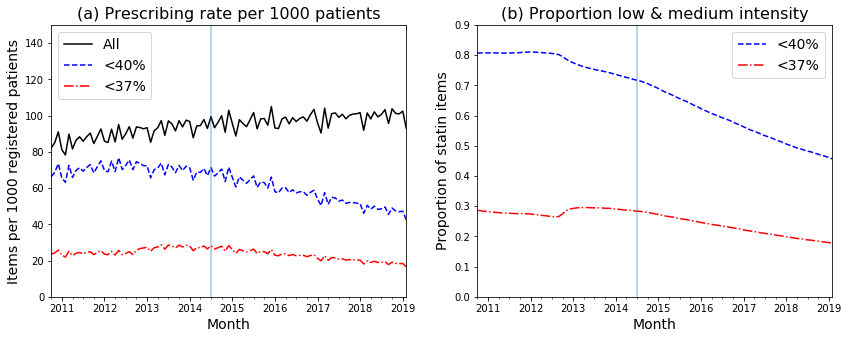

In [17]:
import importlib
from ebmdatalab import charts
importlib.reload(charts)
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

data = national.copy()

s = [(0,'items_per_thou',0,0,'(a) Prescribing rate per 1000 patients','lmdose_items_per_thou'), 
     (1,'proportion_lm',0,1,'(b) Proportion low & medium intensity','proportion_lm_hp'),
    ]

fig = plt.figure(figsize=(14,5)) 

gs = gridspec.GridSpec(1,2)  # grid layout for subplots

ax = plt.subplot(gs[0, 0])
ylabel = "Items per 1000 registered patients"
ylim = [0, 150]
legend = ['All', '<40%', '<37%']
title = '(a) Prescribing rate per 1000 patients'
c1 = 'k'
c2= 'b'
c3 = 'r'
data.plot('month', 'items_per_thou', ax=ax, color=c1)
data.plot('month', 'lmdose_items_per_thou', ax=ax, ls='--', color=c2)
data.plot('month', 'lmhp_items_per_thou', ax=ax, ls='-.', color=c3)
plt.legend(legend, loc='upper left', fontsize=14)
ax.set_title(title, size = 16)
ax.set_ylim(ylim)
ax.set_ylabel(ylabel, size = 14)
ax.set_xlabel("Month", size = 14)
ax.axvline("2014-07-01", alpha=0.4)

ax = plt.subplot(gs[0, 1])
ylabel = "Proportion of statin items"
ylim = [0, 0.9]
legend = ['<40%', '<37%']
title = '(b) Proportion low & medium intensity'
c1 = 'b'
c2 = 'r'

data.plot('month', 'proportion_lm', ax=ax, ls='--', color=c1)
data.plot('month', 'proportion_lm_hp', ls='-.', ax=ax, color=c2)
plt.legend(legend, loc='upper right', fontsize=14)
ax.set_title(title, size = 16)
ax.set_ylabel(ylabel, size = 14)
ax.set_xlabel("Month", size = 14)
ax.set_ylim(ylim)
ax.axvline("2014-07-01", alpha=0.4)

plt.savefig("statinprescribing_fig1.tif",dpi=200)
plt.show()


### Count practices

In [34]:
stats = prac.copy().groupby(["practice","month"]).sum().reset_index()

stats = stats.merge(prac_p,on=["month","practice"])
print ( stats["practice"].nunique(), "total practices included" )
print ( stats.loc[pd.DatetimeIndex(stats['month']).year==2018].nunique()["practice"], "practices included in 2018" )

8142 total practices included
7210 practices included in 2018


### Calculate gradient for proportion lm dose chart

In [18]:
print(national[["month","proportion_lm"]].loc[23])
print(national[["month","proportion_lm"]].loc[100])
print(national[["month","proportion_lm"]].loc[23]-national[["month","proportion_lm"]].loc[100])
print (0.348963/(2344/365), "decrease per year")
print (0.348963/(2344/30.5), "decrease per month")

month            2012-09-01 00:00:00+00:00
proportion_lm                     0.801714
Name: 23, dtype: object
month            2019-02-01 00:00:00+00:00
proportion_lm                     0.456849
Name: 100, dtype: object
month            -2344 days +00:00:00
proportion_lm                0.344864
dtype: object
0.054339375 decrease per year
0.0045406875000000005 decrease per month


## Deciles for practices

### Rearrange data to give items per 1000 for each chemical as a column
Also select top chemicals, grouping the rest into "other"

In [19]:
prac.head()

,pct,practice,chemical,items,actual_cost,quantity,month,low_med_dose_items,low_med_dose_items_hi_pri,proportion_lm
0,99E,F81666,Simvastatin,211,278.81,5861,2010-08-01 00:00:00+00:00,211,101,1.0
1,10X,J82619,Atorvastatin,20,616.20,924,2010-08-01 00:00:00+00:00,10,0,0.5
2,03J,B85008,Fluvastatin Sodium,2,13.72,56,2010-08-01 00:00:00+00:00,2,2,1.0
3,15D,K81046,Pravastatin Sodium,12,63.61,588,2010-08-01 00:00:00+00:00,12,12,1.0
4,04G,K83010,Pravastatin Sodium,36,93.51,847,2010-08-01 00:00:00+00:00,36,36,1.0


In [20]:
prac_deciles = prac.copy()

# group up chemicals to top 5 and "other"
conditions = [
    (prac_deciles["chemical"] == "Pravastatin Sodium"),
    (prac_deciles["chemical"] == "Rosuvastatin Calcium"),
    (prac_deciles["chemical"] == "Simvastatin"),
    (prac_deciles["chemical"] == "Atorvastatin"),
    (prac_deciles["chemical"] == "Fluvastatin Sodium")]
choices = ["Pravastatin Sodium","Rosuvastatin Calcium","Simvastatin","Atorvastatin","Fluvastatin"]
prac_deciles['chem2'] = np.select(conditions, choices, default='other statins')

prac_deciles = prac_deciles.groupby(["month","practice","chem2"],as_index=False).sum()


prac_deciles = prac_deciles.set_index(["month","practice","chem2"]).unstack()
prac_deciles["items","total"] = prac_deciles["items"].sum(axis=1)
prac_deciles["low_med_dose_items","total"] = prac_deciles["low_med_dose_items"].sum(axis=1)
prac_deciles["low_med_dose_items_hi_pri","total"] = prac_deciles["low_med_dose_items_hi_pri"].sum(axis=1)

prac_deciles.sort_index(axis=1,inplace=True)
prac_deciles = prac_deciles.stack().reset_index()

# join prac population data and calc items & cost per 1000
prac_deciles = prac_deciles.merge(prac_p, on=["practice","month"])
prac_deciles["items_per_thou"] = 1000*prac_deciles["items"]/prac_deciles["total_list_size"]
prac_deciles["lmdose_items_per_thou"] = 1000*prac_deciles["low_med_dose_items"]/prac_deciles["total_list_size"]
prac_deciles["lm_hp_items_per_thou"] = 1000*prac_deciles["low_med_dose_items_hi_pri"]/prac_deciles["total_list_size"]
prac_deciles["proportion_lm"] = prac_deciles["low_med_dose_items"]/prac_deciles["items"]
prac_deciles["proportion_lm_hp"] = prac_deciles["low_med_dose_items_hi_pri"]/prac_deciles["items"]

# reduce to required columns and set index
prac_deciles = prac_deciles[["month","practice","chem2","items_per_thou","lmdose_items_per_thou", "lm_hp_items_per_thou", "proportion_lm", "proportion_lm_hp"]].set_index(["month","practice","chem2"]).unstack().reset_index().replace([np.inf, -np.inf], np.nan).fillna(0)


prac_deciles.columns = ['_'.join(tup).rstrip('_') for tup in prac_deciles.columns.values]

prac_deciles.head(-20)

,month,practice,items_per_thou_Atorvastatin,items_per_thou_Fluvastatin,items_per_thou_Pravastatin Sodium,items_per_thou_Rosuvastatin Calcium,items_per_thou_Simvastatin,items_per_thou_other statins,items_per_thou_total,lmdose_items_per_thou_Atorvastatin,...,proportion_lm_Simvastatin,proportion_lm_other statins,proportion_lm_total,proportion_lm_hp_Atorvastatin,proportion_lm_hp_Fluvastatin,proportion_lm_hp_Pravastatin Sodium,proportion_lm_hp_Rosuvastatin Calcium,proportion_lm_hp_Simvastatin,proportion_lm_hp_other statins,proportion_lm_hp_total
0,2010-10-01 00:00:00+00:00,A81001,20.042443,1.178967,2.593728,0.943174,50.931384,0.000000,75.689696,1.414761,...,1.000000,0.0,0.744548,0.000000,1.0,1.0,0.0,0.185185,0.0,0.174455
1,2010-10-01 00:00:00+00:00,A81002,21.426832,0.097395,1.899196,5.843682,59.215973,0.000000,88.483078,3.749696,...,1.000000,0.0,0.737479,0.000000,1.0,1.0,0.0,0.105263,0.0,0.093010
2,2010-10-01 00:00:00+00:00,A81003,15.380464,0.000000,4.587156,1.079331,110.091743,0.000000,131.138694,5.666487,...,1.000000,0.0,0.917695,0.000000,0.0,1.0,0.0,0.340686,0.0,0.320988
3,2010-10-01 00:00:00+00:00,A81004,21.862648,0.000000,3.458498,1.482213,47.060277,0.000000,73.863636,4.323123,...,0.994751,0.0,0.740803,0.000000,0.0,1.0,0.0,0.238845,0.0,0.198997
4,2010-10-01 00:00:00+00:00,A81005,28.481807,0.125471,5.771644,1.882058,100.376412,0.000000,136.637390,7.151819,...,0.962500,0.0,0.802571,0.000000,1.0,1.0,0.0,0.478750,0.0,0.394858
5,2010-10-01 00:00:00+00:00,A81006,28.759444,0.162483,2.599724,2.599724,73.523438,0.568690,108.213502,7.067999,...,0.996685,1.0,0.774775,0.000000,1.0,1.0,0.0,0.253039,1.0,0.202703
6,2010-10-01 00:00:00+00:00,A81007,4.516990,0.307977,3.901037,0.205318,70.937275,0.307977,80.176573,1.026589,...,0.997106,1.0,0.951344,0.000000,1.0,1.0,0.0,0.162084,1.0,0.199744
7,2010-10-01 00:00:00+00:00,A81008,27.495379,0.231054,0.462107,9.011091,175.831793,2.310536,215.341959,1.617375,...,0.998686,1.0,0.836910,0.000000,1.0,1.0,0.0,0.236531,1.0,0.207082
8,2010-10-01 00:00:00+00:00,A81009,21.709203,0.635391,3.282855,1.164884,84.295245,0.105899,111.193477,3.918246,...,0.996231,1.0,0.826667,0.000000,1.0,1.0,0.0,0.251256,1.0,0.226667
9,2010-10-01 00:00:00+00:00,A81011,15.090350,0.000000,1.633987,0.672818,73.913879,0.000000,91.311034,1.826221,...,0.998700,0.0,0.846316,0.000000,0.0,1.0,0.0,0.327698,0.0,0.283158


### Plot practice deciles for statin prescribing by chemical per 1000 patients

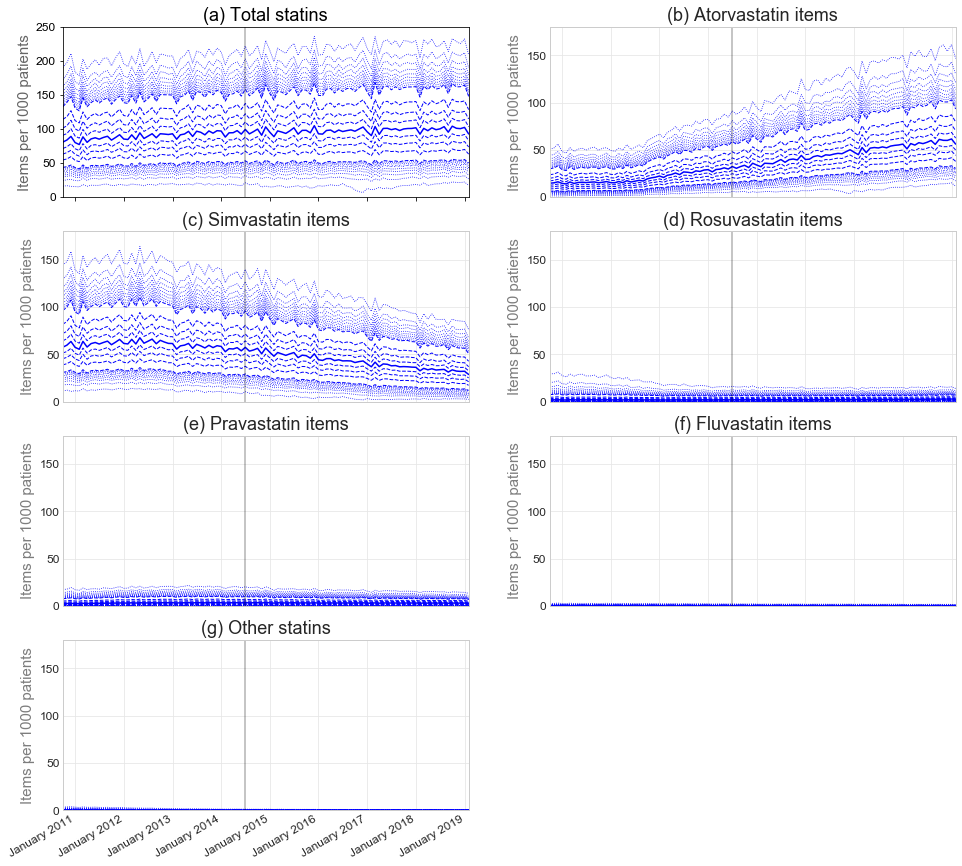

In [21]:
import importlib
from ebmdatalab import charts
importlib.reload(charts)
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

data = prac_deciles

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'total',0,0,'(a) Total statins'), 
     (1,'Atorvastatin',0,1,'(b) Atorvastatin items'),
     (2,'Simvastatin',1,0,'(c) Simvastatin items'),
     (3,'Rosuvastatin Calcium',1,1,'(d) Rosuvastatin items'),
     (4,'Pravastatin Sodium',2,0,'(e) Pravastatin items'),
     (5,'Fluvastatin',2,1,'(f) Fluvastatin items'),
     (6,'other statins',3,0,'(g) Other statins')]


fig = plt.figure(figsize=(16,16)) 


gs = gridspec.GridSpec(4,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    if i[3]==2:
        legend = True
    else:
        legend = False
    
    plt = charts.deciles_chart(
        data,
        period_column='month',
        column="items_per_thou_"+i[1],
        title=i[4],
        ylabel="Items per 1000 patients",
        show_outer_percentiles=True,
        show_legend=legend,
        ax=ax)
    if i[0]==0:
        ax.set_ylim([0, 250])
    else:
        ax.set_ylim([0, 180])
    ax.axvline("2014-07-01", alpha=0.3, color='k')

fig.autofmt_xdate()
plt.show()

### Plot practice deciles for low/medium intensity items proportion and per 1000 patients, at both threshold limits

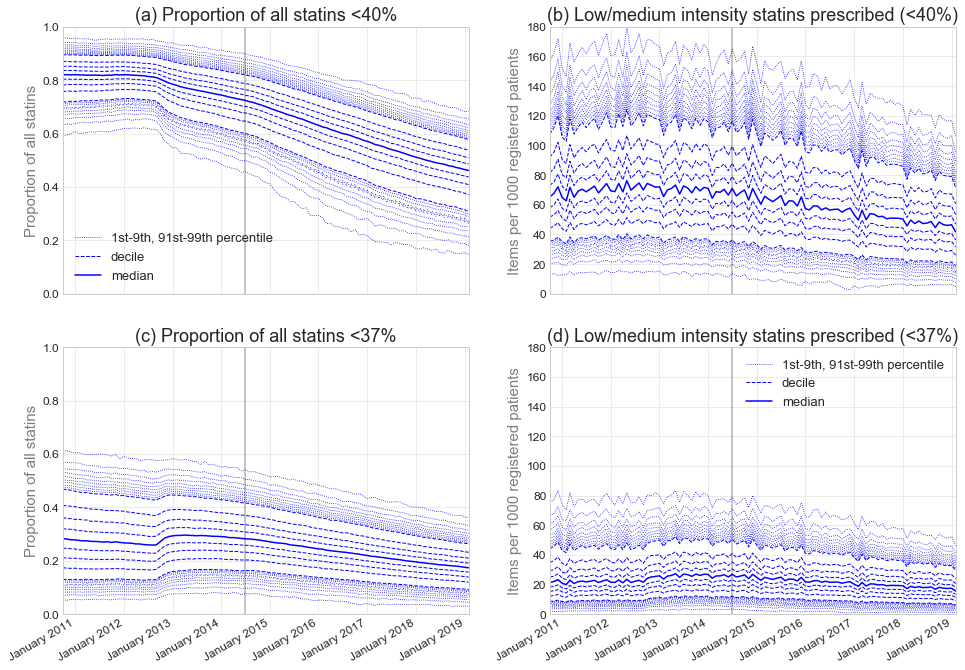

In [22]:
import importlib
from ebmdatalab import charts
importlib.reload(charts)
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

data = prac_deciles

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'proportion_lm_total',0,0,'(a) Proportion of all statins <40%'),
     (1,'lmdose_items_per_thou_total',0,1,'(b) Low/medium intensity statins prescribed (<40%)'),
     (2,'proportion_lm_hp_total',1,0,'(c) Proportion of all statins <37%'),
     (3,'lm_hp_items_per_thou_total',1,1,'(d) Low/medium intensity statins prescribed (<37%)')
    ]


fig = plt.figure(figsize=(16,12)) 



gs = gridspec.GridSpec(2,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    if i[3]==1: # set positions at which to display the legend
        ylabel="Items per 1000 registered patients"
    else:
        ylabel="Proportion of all statins"
    plt = charts.deciles_chart(
        data,
        period_column='month',
        column=i[1],
        title=i[4],
        ylabel=ylabel,
        show_outer_percentiles=True,
        ax=ax)
    if i[3]==1:
        ax.set_ylim([0, 180])
    else:
        ax.set_ylim([0, 1])
    if i[0]==3:
        ax.legend(loc='upper right', fontsize=13)
    elif i[0]==0:
        ax.legend(loc='lower left', fontsize=13)
    else:
        ax.legend().remove()
    ax.axvline("2014-07-01", alpha=0.3, color='k')
    

fig.autofmt_xdate()

plt.savefig("statinprescribing_fig3.tif",dpi=200)

plt.show()

### Plot practice deciles for low/medium intensity items as proportion of each chemical

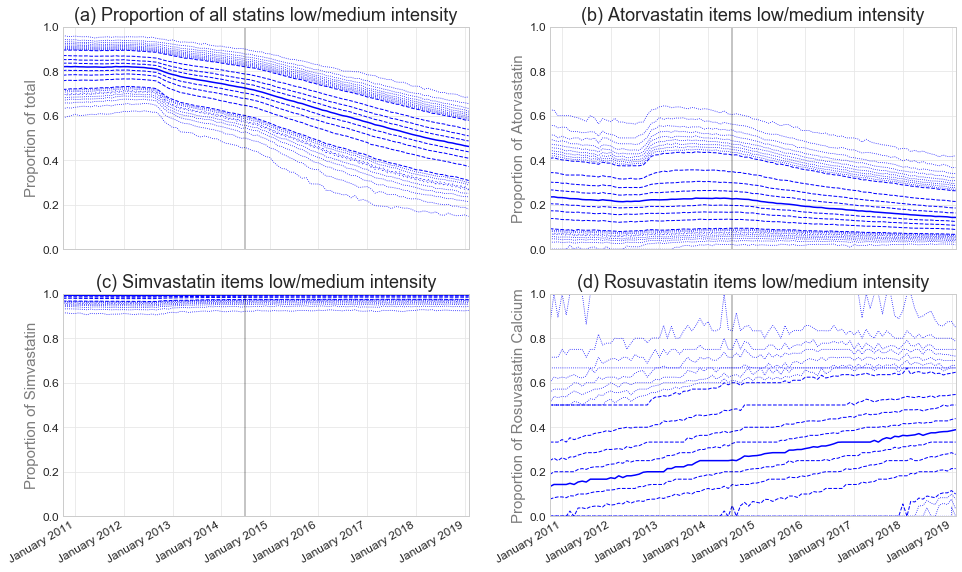

In [23]:
import importlib
from ebmdatalab import charts
importlib.reload(charts)
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

data = prac_deciles

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'total',0,0,'(a) Proportion of all statins low/medium intensity'), 
     (1,'Atorvastatin',0,1,'(b) Atorvastatin items low/medium intensity'),
     (2,'Simvastatin',1,0,'(c) Simvastatin items low/medium intensity'),
     (3,'Rosuvastatin Calcium',1,1,'(d) Rosuvastatin items low/medium intensity')]


fig = plt.figure(figsize=(16,10)) 


gs = gridspec.GridSpec(2,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    if i[3]==2:
        legend = True
    else:
        legend = False
    
    plt = charts.deciles_chart(
        data,
        period_column='month',
        column="proportion_lm_"+i[1],
        title=i[4],
        ylabel="Proportion of "+i[1],
        show_outer_percentiles=True,
        show_legend=legend,
        ax=ax)
    if i[0]==0:
        ax.set_ylim([0, 1])
    else:
        ax.set_ylim([0, 1])
    ax.axvline("2014-07-01", alpha=0.3, color='k')    
        

fig.autofmt_xdate()
plt.show()

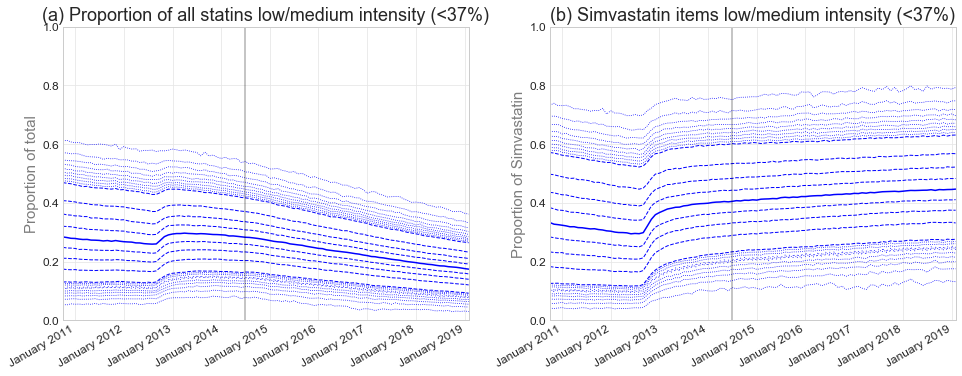

In [24]:
import importlib
from ebmdatalab import charts
importlib.reload(charts)
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

data = prac_deciles

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'total',0,0,'(a) Proportion of all statins low/medium intensity (<37%)'), 
     (1,'Simvastatin',0,1,'(b) Simvastatin items low/medium intensity (<37%)')]


fig = plt.figure(figsize=(16,6)) 


gs = gridspec.GridSpec(1,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    if i[3]==2:
        legend = True
    else:
        legend = False
    
    plt = charts.deciles_chart(
        data,
        period_column='month',
        column="proportion_lm_hp_"+i[1],
        title=i[4],
        ylabel="Proportion of "+i[1],
        show_outer_percentiles=True,
        show_legend=legend,
        ax=ax)
    if i[0]==0:
        ax.set_ylim([0, 1])
    else:
        ax.set_ylim([0, 1])
    ax.axvline("2014-07-01", alpha=0.3, color='k')
        
fig.autofmt_xdate()
plt.show()

# Regression analysis

In [31]:
import datetime as dt

regr = prac.copy()
#limit to 2018
regr = regr.loc[pd.DatetimeIndex(regr['month']).year==2018]
regr["year"] = pd.DatetimeIndex(regr['month']).year

# sum across all statins
regr = regr.groupby(["practice","month","year"])["items","low_med_dose_items","low_med_dose_items_hi_pri"].sum().reset_index()

# join to practices to exclude any non-standard ones
regr = regr.merge(prac_p, on=["practice","month"], how = "inner") 

regr2 = regr.groupby(["practice","year"])["items","low_med_dose_items","low_med_dose_items_hi_pri"].sum().reset_index()

regr2["proportion_lm_dose"] = regr2["low_med_dose_items"]/regr2["items"] 
regr2["proportion_lm_dose_hp"] = regr2["low_med_dose_items_hi_pri"]/regr2["items"] 

regr2.reset_index().to_csv("statins_proportion_for_regression_filtered.csv")
regr2.head()

,practice,year,items,low_med_dose_items,low_med_dose_items_hi_pri,proportion_lm_dose,proportion_lm_dose_hp
0,A81001,2018,5261,2266,705,0.430717,0.134005
1,A81002,2018,30575,12199,3582,0.398986,0.117155
2,A81004,2018,13974,5234,2408,0.374553,0.172320
3,A81005,2018,15779,7366,4476,0.466823,0.283668
4,A81006,2018,26783,10885,4139,0.406415,0.154538


### boxplot

In [32]:
import numpy as np

prac_2018 = regr.copy()
prac_2018["items_per_thou"] = 1000*prac_2018["items"]/prac_2018["total_list_size"]
prac_2018["proportion_lm_dose"] = prac_2018["low_med_dose_items"]/prac_2018["items"] 

# filter out those with very small list size
prac_2018 = prac_2018.loc[prac_2018["total_list_size"]>500]

prac_2018["prescribing_decile"] = np.ceil(prac_2018["items_per_thou"].rank(pct=True)*10)
prac_2018.sort_values(by="items_per_thou",ascending=False).head()

,practice,month,year,items,low_med_dose_items,low_med_dose_items_hi_pri,total_list_size,items_per_thou,proportion_lm_dose,prescribing_decile
85008,Y06007,2018-06-01 00:00:00+00:00,2018,606,269,91,813.0,745.387454,0.443894,10.0
73294,N84624,2018-01-01 00:00:00+00:00,2018,678,373,139,976.0,694.672131,0.550147,10.0
83602,Y02711,2018-05-01 00:00:00+00:00,2018,572,148,65,906.0,631.346578,0.258741,10.0
73295,N84624,2018-02-01 00:00:00+00:00,2018,583,319,118,990.0,588.888889,0.547170,10.0
4703,A89026,2018-04-01 00:00:00+00:00,2018,1651,1061,363,2996.0,551.068091,0.642641,10.0


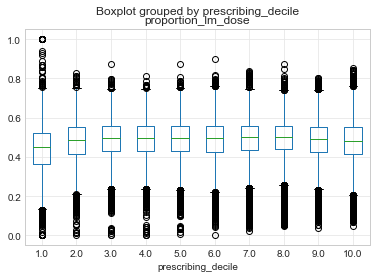

In [33]:
prac_2018.boxplot(column="proportion_lm_dose", by="prescribing_decile")

plt.show()

# CCG data

### CCG population data

In [37]:
sql_ccg_p = '''
SELECT pct_id AS pct, month, SUM(total_list_size) AS total_list_size
FROM ebmdatalab.hscic.practice_statistics_all_years stat
LEFT JOIN ebmdatalab.hscic.practices p on stat.practice = p.code
WHERE p.setting = 4 -- only standard practices
GROUP BY pct, month'''

ccg_p = bq.cached_read(sql_ccg_p, csv_path='ccg_p.csv', use_cache=False)  # add `use_cache=False` to override


ccg_p["total_list_size"] = ccg_p["total_list_size"].astype("float")
ccg_p["month"]= pd.to_datetime(ccg_p.month)
ccg_p.info()

C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22852 entries, 0 to 22851
Data columns (total 3 columns):
pct                22852 non-null object
month              22852 non-null datetime64[ns, UTC]
total_list_size    22852 non-null float64
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 535.7+ KB


## Calculate proportion low-medium dose at CCG level

In [38]:
import numpy as np
import pandas as pd
from ebmdatalab import maps
import datetime as dt

ccg_last_year =  prac.copy().groupby(["pct","month"]).sum().reset_index()
ccg_last_year =  ccg_last_year.loc[pd.DatetimeIndex(ccg_last_year['month']).year==2018]
# join on list sizes:
ccg_last_year["month"] = pd.to_datetime(ccg_last_year["month"], utc = True)
ccg_p["month"] = pd.to_datetime(ccg_p["month"], utc = True)
ccg_last_year = ccg_last_year.merge(ccg_p, on=["pct","month"])

ccg_last_year["proportion_lm"] = ccg_last_year["low_med_dose_items"]/ccg_last_year["items"]
ccg_last_year["proportion_lm_hp"] = ccg_last_year["low_med_dose_items_hi_pri"]/ccg_last_year["items"]

ccg_last_year.describe()


,items,actual_cost,quantity,low_med_dose_items,low_med_dose_items_hi_pri,proportion_lm,total_list_size,proportion_lm_hp
count,2344.000000,2344.000000,2.344000e+03,2344.000000,2344.000000,2344.000000,2.344000e+03,2344.000000
mean,29811.807167,37967.122718,9.697558e+05,14443.651024,5655.502560,0.482174,2.969506e+05,0.188708
std,17614.126497,22700.286384,5.520804e+05,8827.035052,3582.747786,0.073771,1.757876e+05,0.042265
min,1.000000,0.177360,3.000000e+00,0.000000,0.000000,0.000000,7.470000e+02,0.000000
25%,17305.500000,23325.138263,6.017668e+05,8602.750000,3308.000000,0.453836,1.867152e+05,0.163703
50%,25543.000000,32302.201590,8.093500e+05,12034.000000,4707.500000,0.489561,2.551255e+05,0.188695
75%,37803.500000,46061.522073,1.182780e+06,17944.000000,6874.250000,0.524649,3.331358e+05,0.216563
max,110284.000000,169965.096970,4.445993e+06,56666.000000,22450.000000,1.000000,1.319731e+06,0.363636


# Maps

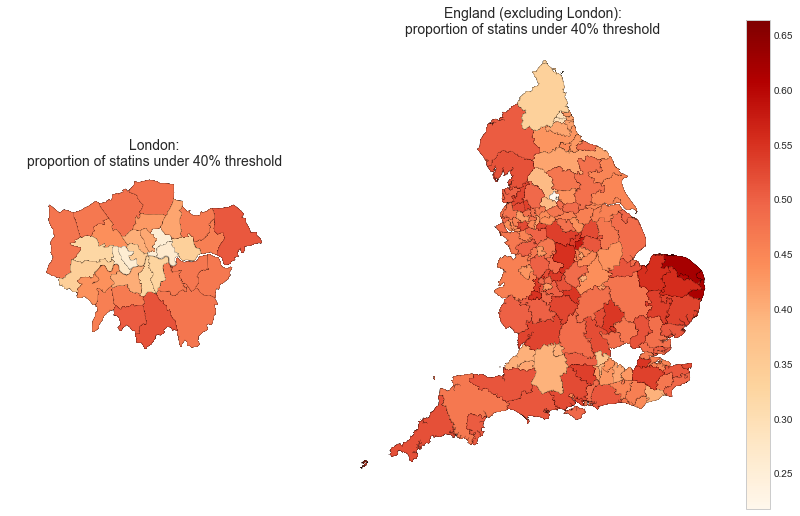

In [39]:
import matplotlib.pyplot as plt 
import importlib
from ebmdatalab import maps
importlib.reload(maps)

plt.figure(figsize=(14,9))
data = ccg_last_year

data= data.loc[(data["pct"]!='112') &(data["pct"]!='NV6') & (data["pct"]!= 'RXA')] # exclude non-CCG organisations

maps.ccg_map(data, title="proportion of statins under 40% threshold", column='proportion_lm', map_year='2019', separate_london=True)

plt.savefig("statinprescribing_fig2a.tif",dpi=200)
plt.show()


<Figure size 1008x648 with 0 Axes>

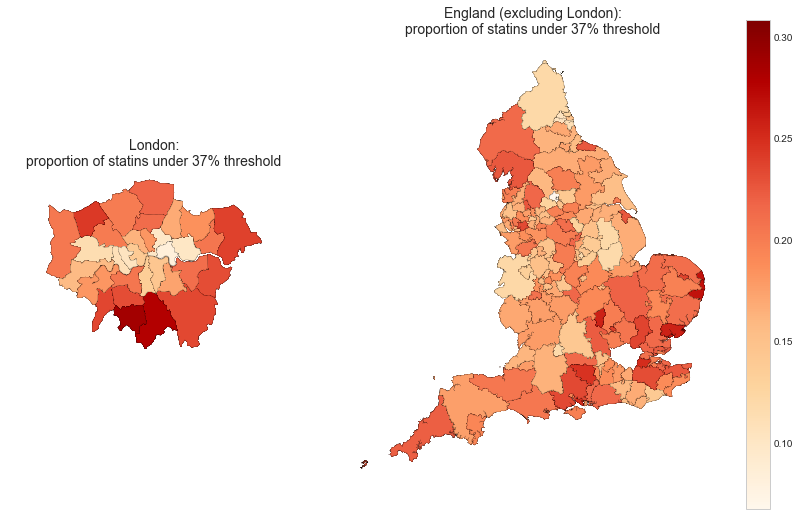

In [42]:
import matplotlib.pyplot as plt 
import importlib
from ebmdatalab import maps
importlib.reload(maps)

plt.figure(figsize=(14,9))
data = ccg_last_year

data= data.loc[(data["pct"]!='112') &(data["pct"]!='NV6') & (data["pct"]!= 'RXA')]

plt = maps.ccg_map(data, title="proportion of statins under 37% threshold", column='proportion_lm_hp', map_year='2019', separate_london=True)

plt.savefig("statinprescribing_fig2b.tif",dpi=200)
plt.show()

# individual formulations

In [56]:
# tablets/capsules only - exclude other formulations such as liquids and powder sachets.

sql = '''SELECT p.month, 
SUM(CASE WHEN concat(SUBSTR(bnf_code,1,9),SUBSTR(bnf_code,-2,2)) IN ('0212000B0AA','0212000B0AL') THEN quantity ELSE 0 END)/SUM(quantity) AS atorvastatin_10mg_quant, 
SUM(CASE WHEN concat(SUBSTR(bnf_code,1,9),SUBSTR(bnf_code,-2,2)) IN ('0212000B0AB', '0212000B0AE', '0212000B0AM') THEN quantity ELSE 0 END)/SUM(quantity) AS atorvastatin_20mg_quant,
SUM(CASE WHEN bnf_code LIKE '0212000B0%AN' THEN quantity ELSE 0 END)/SUM(quantity) AS atorvastatin_30mg_quant,
SUM(CASE WHEN bnf_code LIKE '0212000B0%AC' THEN quantity ELSE 0 END)/SUM(quantity) AS atorvastatin_40mg_quant,
SUM(CASE WHEN bnf_code LIKE '0212000B0%AP' THEN quantity ELSE 0 END)/SUM(quantity) AS atorvastatin_60mg_quant,
SUM(CASE WHEN bnf_code LIKE '0212000B0%AD' THEN quantity ELSE 0 END)/SUM(quantity) AS atorvastatin_80mg_quant, 

SUM(CASE WHEN concat(SUBSTR(bnf_code,1,9),SUBSTR(bnf_code,-2,2)) IN ('0212000Y0AA','0212000Y0AC') THEN quantity ELSE 0 END)/SUM(quantity) AS simvastatin_10mg_quant,
SUM(CASE WHEN bnf_code LIKE '0212000Y0%AB' OR bnf_code LIKE '0212000Y0%AE' THEN quantity ELSE 0 END)/SUM(quantity) AS simvastatin_20mg_quant, 
SUM(CASE WHEN bnf_code LIKE '0212000Y0%AD' THEN quantity ELSE 0 END)/SUM(quantity) AS simvastatin_40mg_quant, 
SUM(CASE WHEN bnf_code LIKE '0212000Y0%AH' THEN quantity ELSE 0 END)/SUM(quantity) AS simvastatin_80mg_quant, 

SUM(CASE WHEN concat(SUBSTR(bnf_code,1,9),SUBSTR(bnf_code,-2,2)) = '0212000AAAD' --Rosuvastatin Calc_Tab 5mg (brand, generic) 
        THEN quantity ELSE 0 END)/SUM(quantity) AS other_marginal,
        
SUM(CASE WHEN concat(SUBSTR(bnf_code,1,9),SUBSTR(bnf_code,-2,2)) IN (
    '0212000AAAA', --Rosuvastatin Calc_Tab 10mg (brand, generic) 
    '0212000AAAB', --Rosuvastatin Calc_Tab 20mg (brand, generic) 
    '0212000AAAC') --Rosuvastatin Calc_Tab 40mg (brand, generic) 
        THEN quantity ELSE 0 END)/SUM(quantity) AS other_high_dose,
        
SUM(CASE WHEN SUBSTR(presentation_code,1,9) NOT IN ('0212000B0','0212000Y0','0212000AA')  THEN quantity ELSE 0 END)/SUM(quantity) AS other_low_medium,

SUM(items) as total_items,
SUM(quantity) as total_quantity,
SUM(stat.total_list_size) AS total_list_size

FROM `ebmdatalab.helen.prescribing_section_2_12` p
INNER JOIN (
select distinct chemical, presentation, presentation_code 
from `hscic.bnf` 
where SUBSTR(presentation_code,1,9) IN (
'0212000AA', --Rosuvastatin Calcium 
'0212000AC', --Simvastatin & Ezetimibe
'0212000B0', --Atorvastatin
'0212000C0', --Cerivastatin 
'0212000M0', --Fluvastatin Sodium
'0212000X0', --Pravastatin Sodium 
'0212000Y0') --Simvastatin)
AND (presentation LIKE "%Tab%" OR presentation LIKE "%Cap%")
) b ON p.bnf_code = b.presentation_code

INNER JOIN ebmdatalab.hscic.practices prac
ON p.practice = prac.code
  AND prac.setting = 4
LEFT JOIN hscic.practice_statistics_all_years stat
ON p.practice = stat.practice and CAST(p.month AS DATE) = CAST(stat.month AS DATE)
  
GROUP BY
month'''

dose = bq.cached_read(sql, csv_path='statins_dose_practice_level.zip')  # add `use_cache=False` to override
dose["month"] = pd.to_datetime(dose.month)

dose.head()

,month,atorvastatin_10mg_quant,atorvastatin_20mg_quant,atorvastatin_30mg_quant,atorvastatin_40mg_quant,atorvastatin_60mg_quant,atorvastatin_80mg_quant,simvastatin_10mg_quant,simvastatin_20mg_quant,simvastatin_40mg_quant,simvastatin_80mg_quant,other_marginal,other_high_dose,other_low_medium,total_items,total_quantity,total_list_size
0,2011-03-01,0.047093,0.057022,0.0,0.069410,0.0,0.022597,0.044989,0.191632,0.473617,0.009086,0.007169,0.030242,0.047143,4899534,171076378,890215786.0
1,2011-04-01,0.046928,0.056774,0.0,0.069484,0.0,0.022782,0.044754,0.191054,0.474637,0.009064,0.007219,0.030186,0.047119,4460560,154975911,879549023.0
2,2011-05-01,0.046958,0.056707,0.0,0.069871,0.0,0.022925,0.044461,0.190240,0.474717,0.009129,0.007326,0.030300,0.047366,4724758,165384346,887690839.0
3,2011-06-01,0.046611,0.056423,0.0,0.069760,0.0,0.023375,0.044076,0.189361,0.476081,0.009147,0.007309,0.030040,0.047816,4827649,167627249,889167824.0
4,2011-07-01,0.046434,0.055835,0.0,0.070037,0.0,0.023497,0.043923,0.188973,0.476750,0.009215,0.007373,0.029690,0.048274,4707012,163972806,890171280.0


In [57]:
# calculations

dose2 = dose.copy()
dose["month"] = pd.to_datetime(dose.month, utc=True)

dose2["items_per_thou"] = 1000*dose2["total_items"]/dose2["total_list_size"]
dose2["quantity_per_thou"] = 1000*dose2["total_quantity"]/dose2["total_list_size"]


dose2.head()

,month,atorvastatin_10mg_quant,atorvastatin_20mg_quant,atorvastatin_30mg_quant,atorvastatin_40mg_quant,atorvastatin_60mg_quant,atorvastatin_80mg_quant,simvastatin_10mg_quant,simvastatin_20mg_quant,simvastatin_40mg_quant,simvastatin_80mg_quant,other_marginal,other_high_dose,other_low_medium,total_items,total_quantity,total_list_size,items_per_thou,quantity_per_thou
0,2011-03-01,0.047093,0.057022,0.0,0.069410,0.0,0.022597,0.044989,0.191632,0.473617,0.009086,0.007169,0.030242,0.047143,4899534,171076378,890215786.0,5.503760,192.174056
1,2011-04-01,0.046928,0.056774,0.0,0.069484,0.0,0.022782,0.044754,0.191054,0.474637,0.009064,0.007219,0.030186,0.047119,4460560,154975911,879549023.0,5.071417,176.199287
2,2011-05-01,0.046958,0.056707,0.0,0.069871,0.0,0.022925,0.044461,0.190240,0.474717,0.009129,0.007326,0.030300,0.047366,4724758,165384346,887690839.0,5.322526,186.308497
3,2011-06-01,0.046611,0.056423,0.0,0.069760,0.0,0.023375,0.044076,0.189361,0.476081,0.009147,0.007309,0.030040,0.047816,4827649,167627249,889167824.0,5.429401,188.521497
4,2011-07-01,0.046434,0.055835,0.0,0.070037,0.0,0.023497,0.043923,0.188973,0.476750,0.009215,0.007373,0.029690,0.048274,4707012,163972806,890171280.0,5.287760,184.203658


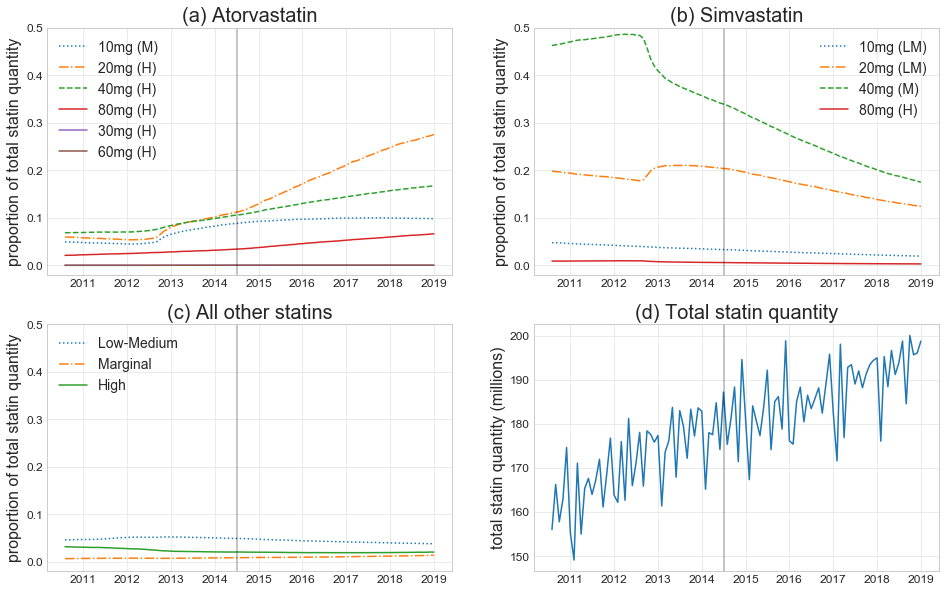

In [59]:
import importlib
from ebmdatalab import charts
importlib.reload(charts)
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

data = dose2.copy().sort_values(by="month")

fig = plt.figure(figsize=(16,10)) 

gs = gridspec.GridSpec(2,2)  # grid layout for subplots

x = data['month']

ax = plt.subplot(gs[0,0])
plt.plot(x, data['atorvastatin_10mg_quant'], ls=':')
plt.plot(x, data['atorvastatin_20mg_quant'], ls='-.')
plt.plot(x, data['atorvastatin_40mg_quant'], ls='--')
plt.plot(x, data['atorvastatin_80mg_quant'])
plt.plot(x, data['atorvastatin_30mg_quant'])
plt.plot(x, data['atorvastatin_60mg_quant'])
plt.title("(a) Atorvastatin", size = 20)
plt.legend(['10mg (M)', '20mg (H)', '40mg (H)', '80mg (H)', '30mg (H)', '60mg (H)'], loc='upper left', fontsize=14)
ax.set_ylim([-.02, 0.5])
ax.set_ylabel("proportion of total statin quantity", size=16)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax.axvline("2014-07-01", alpha=0.3, color='k')

ax = plt.subplot(gs[0,1])
plt.plot(x, data['simvastatin_10mg_quant'], ls=':')
plt.plot(x, data['simvastatin_20mg_quant'], ls='-.')
plt.plot(x, data['simvastatin_40mg_quant'], ls='--')
plt.plot(x, data['simvastatin_80mg_quant'])
plt.title("(b) Simvastatin", size = 20)
plt.legend(['10mg (LM)', '20mg (LM)', '40mg (M)', '80mg (H)'], loc='upper right', fontsize=14)
ax.set_ylim([-.02, 0.5])
ax.set_ylabel("proportion of total statin quantity", size=16)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax.axvline("2014-07-01", alpha=0.3, color='k')

ax = plt.subplot(gs[1,0])
plt.plot(x, data['other_low_medium'], ls=':')
plt.plot(x, data['other_marginal'], ls='-.')
plt.plot(x, data['other_high_dose'])
plt.title("(c) All other statins", size = 20)
plt.legend(['Low-Medium', 'Marginal', 'High'], loc='upper left', fontsize=14)
ax.set_ylim([-.02, 0.5])
ax.set_ylabel("proportion of total statin quantity", size=16)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax.axvline("2014-07-01", alpha=0.3, color='k')

ax = plt.subplot(gs[1,1])
plt.plot(x, data['total_quantity']/1000000)
plt.title("(d) Total statin quantity", size = 20)
ax.set_ylabel("total statin quantity (millions)", size=16)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax.axvline("2014-07-01", alpha=0.3, color='k')

plt.show()
